# Example of Filtering Embedded Pairs

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# System imports
import os
import sys
import yaml
from tqdm import tqdm

# External imports
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.decomposition import PCA
from sklearn.metrics import auc
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.functional as F
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
from pytorch_lightning import Trainer
from sklearn.metrics import precision_recall_curve

import copy

sys.path.append("../..")
from LightningModules.Filter.Models.vanilla_filter import VanillaFilter
from LightningModules.Filter.Models.pyramid_filter import PyramidFilter

device = "cuda" if torch.cuda.is_available() else "cpu"

## Pytorch Lightning Model

In [3]:
with open("example_filter.yaml") as f:
    hparams = yaml.load(f, Loader=yaml.FullLoader)

model = PyramidFilter(hparams)

## The Dataset

In [3]:
from torch_geometric.data import Data

Step 0: Convert old data objects to new PyG data objects

In [4]:
# Load a file from dir
input_dir = "/global/cfs/cdirs/m3443/data/LRT/v3/pileup40_train/embedding_processed/"
output_dir = "/global/cfs/cdirs/m3443/data/LRT/v3/pileup40_train/embedding_processed_Pyg2/"

In [5]:
# Convert from old pyg data to new pyg data
for subdir in ["train", "val", "test"]:
# for subdir in ["train"]:
    all_files = os.listdir(os.path.join(input_dir, subdir))
    all_files = [os.path.join(input_dir, subdir, f) for f in all_files]
    for file in tqdm(all_files):
        if os.path.isfile(os.path.join(output_dir, subdir, os.path.basename(file))):
            continue
        data = torch.load(file, map_location="cpu")
        new_data = Data.from_dict(data.__dict__)
        torch.save(new_data, os.path.join(output_dir, subdir, os.path.basename(file)))

 89%|████████▉ | 3576/4000 [30:34<02:51,  2.47it/s]  

In [11]:
# Check that we can load all the torch files in output_dir
all_files = os.listdir(os.path.join(output_dir, "train"))
all_files = [os.path.join(output_dir, "train", f) for f in all_files]
for file in tqdm(all_files):
    try:
        data = torch.load(file, map_location="cpu")
    except:
        print(file)    

100%|██████████| 1132/1132 [07:15<00:00,  2.60it/s]


To load the data, we call a `setup` method. There is some flexibility in how to handle data, and one should check the Pytorch Lightning docs to see the spectrum of options. This is my favourite way: Hide all of the data loading inside the Lightning module. We are explicitly calling `setup` here because we're going to visualise some of the data first. In future, once you know the nature of the data, we can skip this step, since the trainer will call this automatically when it starts training. 

NOTE: This may take a minute or two, since the data is being trimmed to particles above a certain momentum threshold.

In [4]:
%%time
model.setup(stage="fit")

CPU times: user 1.46 ms, sys: 724 µs, total: 2.18 ms
Wall time: 1.64 ms


### Visualise geometry

Just as a sanity check, let's look directly at the geometry of the data, as well as some distributions. This is just to make sure that, e.g. it's normalised in some reasonable way (that is, it doesn't vary from -1000 to +1000 or some large numbers, but that it is distributed close to +1 and -1 - this makes training much more effective!), and there aren't weird outliers (this also damages training!). 

In [5]:
trainset = model.trainset

In [6]:
example_data = trainset[0]
r, phi, z = example_data.x.T

In [40]:
x, y = r * np.cos(phi * np.pi) * 1000, r * np.sin(phi * np.pi) * 1000
z = z * 1000

(Text(0.5, 1.0, 'Down-beampipe Spacepoint Distribution'),
 Text(0.5, 0, 'x direction (mm)'),
 Text(0, 0.5, 'y direction (mm)'))

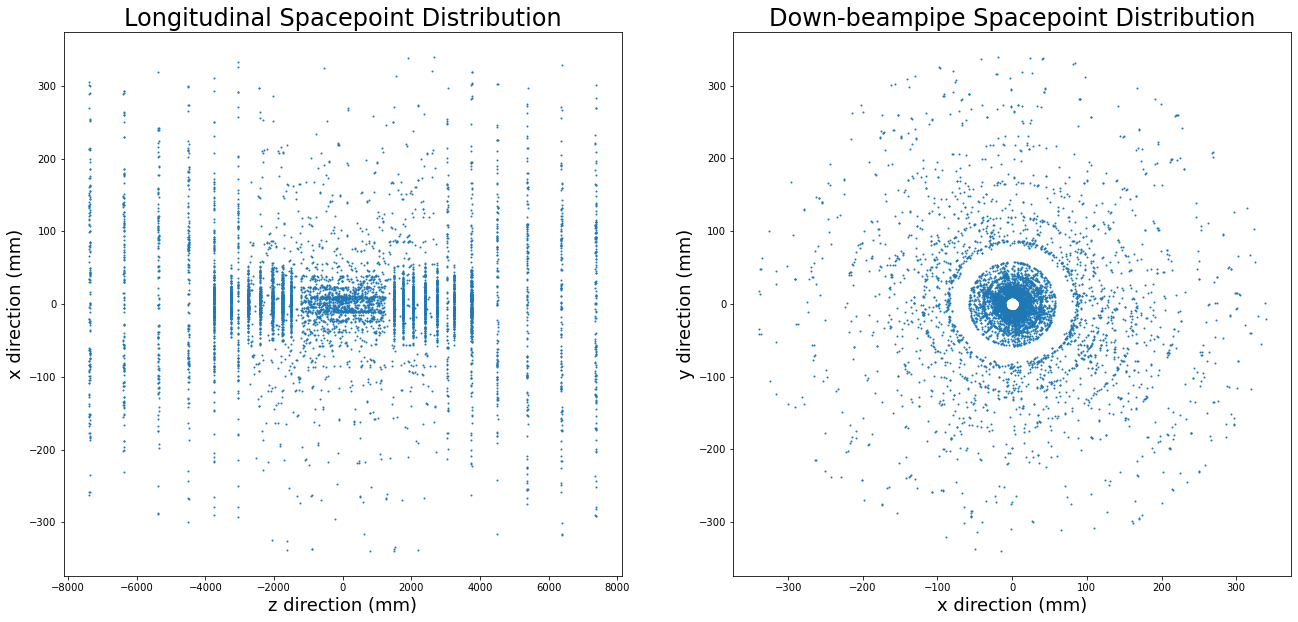

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(22, 10))
axs[0].scatter(z, x, s=1)
axs[1].scatter(x, y, s=1)
axs[0].set_title("Longitudinal Spacepoint Distribution", fontsize=24), axs[
    0
].set_xlabel("z direction (mm)", fontsize=18), axs[0].set_ylabel(
    "x direction (mm)", fontsize=18
)
axs[1].set_title("Down-beampipe Spacepoint Distribution", fontsize=24), axs[
    1
].set_xlabel("x direction (mm)", fontsize=18), axs[1].set_ylabel(
    "y direction (mm)", fontsize=18
)

### Visualise distributions

(Text(0.5, 1.0, 'Distribution of Momentum'),
 Text(0.5, 0, 'pT (GeV)'),
 Text(0, 0.5, 'Count'))

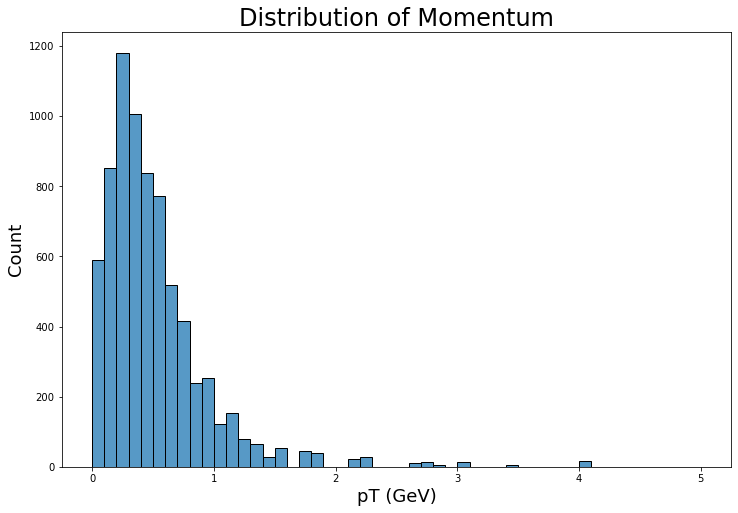

In [44]:
plt.figure(figsize=(12, 8))
sns.histplot(
    example_data.pt[example_data.pt == example_data.pt],
    binwidth=0.1,
    binrange=[0, 5],
)
plt.title("Distribution of Momentum", fontsize=24), plt.xlabel(
    "pT (GeV)", fontsize=18
), plt.ylabel("Count", fontsize=18)

Observe the hard cut-off below 1GeV - this is because we are ignoring lower energy hits to keep things easy for now. But we should include them again once we are happy with our ML architecture!

In [45]:
particle_num, particle_counts = np.unique(example_data.pid.numpy(), return_counts=True)

(Text(0.5, 1.0, 'Distribution of Hits per Particle'),
 Text(0.5, 0, 'Hits'),
 Text(0, 0.5, 'Count'))

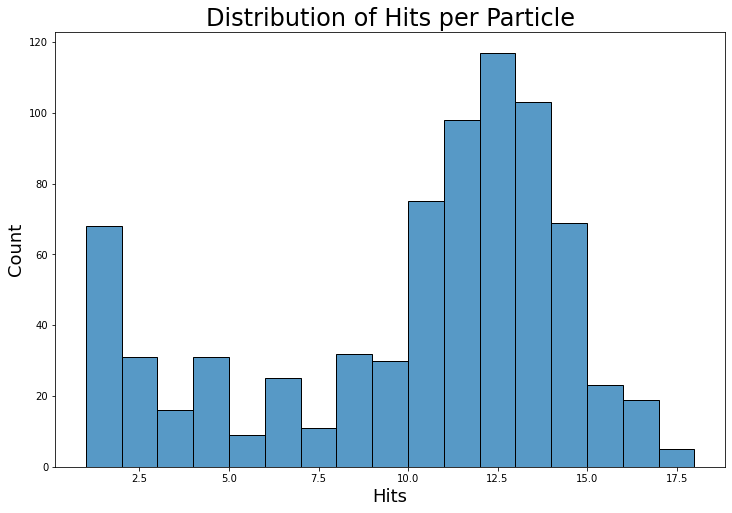

In [46]:
plt.figure(figsize=(12, 8))
sns.histplot(particle_counts[:-1], binwidth=1)
plt.title("Distribution of Hits per Particle", fontsize=24), plt.xlabel(
    "Hits", fontsize=18
), plt.ylabel("Count", fontsize=18)

This gives an idea about how long each particle track is. We can see that most particle tracks leave > 10 hits, which will be useful for our graph neural networks down the track. In general, shorter tracks are harder to detect, and less useful for doing meaningful physics.

## Metric Learning

### Train filter

Finally! Let's train! We instantiate a `Trainer` class that knows things like which hardware to work with, how long to train for, and a **bunch** of default options that we ignore here. Check out the Trainer class docs in Pytorch Lightning. Suffice it to say that it clears away much repetitive boilerplate in training code.

In [4]:
logger = WandbLogger(project="LRT_mu40_1GeV_Filter", group="InitialTest")
trainer = Trainer(gpus=1, max_epochs=100, num_sanity_val_steps=1, logger=logger)
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: murnanedaniel. Use `wandb login --relogin` to force relogin



  | Name         | Type       | Params
--------------------------------------------
0 | input_layer  | Linear     | 7.2 K 
1 | layers       | ModuleList | 689 K 
2 | output_layer | Linear     | 129   
3 | act          | Tanh       | 0     
--------------------------------------------
696 K     Trainable params
0         Non-trainable params
696 K     Total params
2.785     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/global/homes/d/danieltm/.conda/envs/exatrkx-gpu/lib/python3.8/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


RuntimeError: CUDA out of memory. Tried to allocate 1.27 GiB (GPU 0; 39.59 GiB total capacity; 83.10 MiB already allocated; 164.19 MiB free; 114.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## Performance

In [28]:
checkpoint_path = "/global/cscratch1/sd/danieltm/ExaTrkX/lightning_checkpoints/LRT_mu40_0GeV_Filter/ydyoy5l8/checkpoints/last.ckpt"
checkpoint = torch.load(checkpoint_path)

model = PyramidFilter.load_from_checkpoint(checkpoint_path).to(device)

In [29]:
model.eval();

In [30]:
model.hparams["datatype_split"] = [1, 1, 10]

In [31]:
model.setup(stage="fit")

In [48]:
with torch.no_grad():
    test_results = model.test_step(model.testset[5].to(device), 0)

In [49]:
cut = 0.15

In [50]:
(test_results["truth"] & (test_results["preds"] > cut)).sum() / (
    test_results["preds"] > cut
).sum()

tensor(0.0193, device='cuda:0')

In [51]:
(test_results["truth"] & (test_results["preds"] > cut)).sum() / test_results[
    "truth"
].int().sum()

tensor(0.9925, device='cuda:0')

In [24]:
pur, eff, thresh = precision_recall_curve(
    test_results["trues"].cpu().int().numpy(),
    test_results["preds"].cpu().numpy(),
    pos_label=1,
)

(0.0, 0.1)

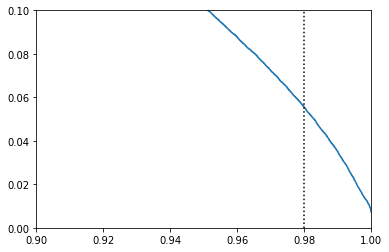

In [25]:
plt.plot(eff, pur)
plt.plot([0.98, 0.98], [0, 1], "k:")
plt.xlim([0.9, 1.0])
plt.ylim([0.0, 0.1])

### Test metrics

In [27]:
all_efficiencies, all_purities = [], []
all_radius = np.arange(0.5, 1.2, 0.1)

with torch.no_grad():

    model.hparams.r_test = r
    test_results = trainer.test(ckpt_path=None)

    # Get eff, pur

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.29412952065467834,
 'pur': 0.31158846616744995,
 'val_loss': 0.8040090799331665}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.5026120543479919,
 'pur': 0.3214113712310791,
 'val_loss': 0.828713059425354}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.6482229828834534,
 'pur': 0.2828279137611389,
 'val_loss': 0.8727149963378906}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.745759904384613,
 'pur': 0.23499229550361633,
 'val_loss': 0.9117689728736877}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.8200681805610657,
 'pur': 0.18902744352817535,
 'val_loss': 0.9429423809051514}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.8717353343963623,
 'pur': 0.15006624162197113,
 'val_loss': 0.9644220471382141}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.9083821177482605,
 'pur': 0.12099817395210266,
 'val_loss': 0.9782997965812683}
--------------------------------------------------------------------------------


In [ ]:
eta_cuts = np.arange(-4, 4, 0.1)
pt_cuts = np.arange(1, 5, 0.5)

av_eta = test_results[""]
av_pt

for eta in eta_cuts

We should always visualise two important metrics: the efficiency (the number of true positives divided by the total number of possible true edges) and the purity (the number of true positives divided by the number of predicted edges). Is it clear to you why the graphs below behave as they do, as we widen the sphere around each hit to generate neighboring edges?

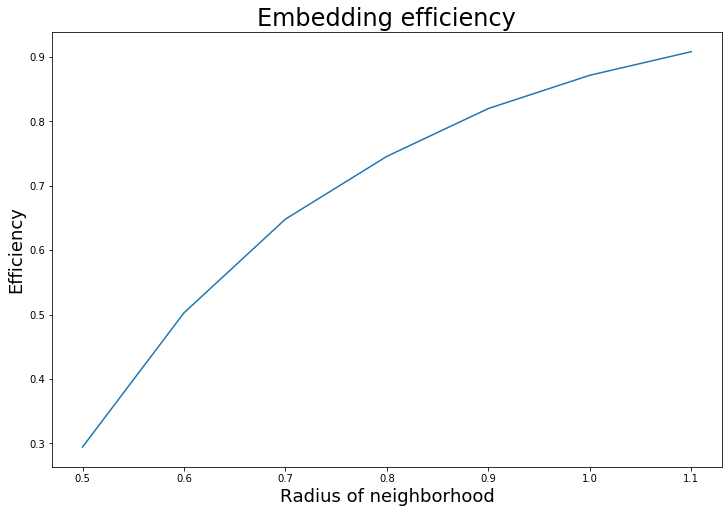

In [28]:
plt.figure(figsize=(12, 8))
plt.plot(all_radius, all_efficiencies)
plt.title("Embedding efficiency", fontsize=24), plt.xlabel(
    "Radius of neighborhood", fontsize=18
), plt.ylabel("Efficiency", fontsize=18);

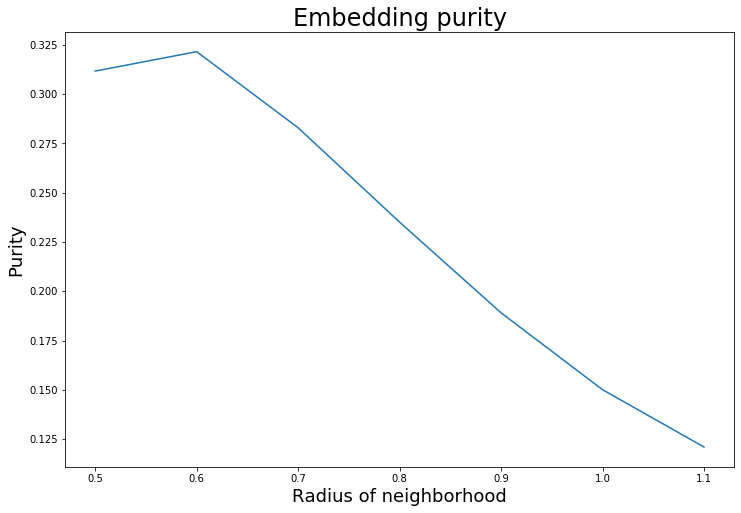

In [29]:
plt.figure(figsize=(12, 8))
plt.plot(all_radius, all_purities)
plt.title("Embedding purity", fontsize=24), plt.xlabel(
    "Radius of neighborhood", fontsize=18
), plt.ylabel("Purity", fontsize=18);

### Visualise embedding / latent space

Another useful thing to visualise is the actual space being embedded into. Since it's 8 dimensional, we can reduce it to 2 dimensions with "Principal Component Analysis". 

In [24]:
from sklearn.decomposition import PCA

In [25]:
example_data = trainset[0]
particle_ids = example_data.pid
cyl_coords = example_data.x
cell_features = example_data.cell_data
all_features = torch.cat([cyl_coords, cell_features], axis=-1).to("cuda")

In [26]:
latent_features = model(all_features)

In [27]:
pca = PCA(n_components=2)

In [28]:
reduced_dimensions = pca.fit_transform(latent_features.detach().cpu())

In [29]:
reduced_dimensions

array([[-8.95513417, -3.68551328],
       [-9.26373197, -2.57803677],
       [17.49976278,  3.70361098],
       ...,
       [16.35837063, -5.6276739 ],
       [17.72111695, -4.57634675],
       [13.94139828, -8.52278351]])

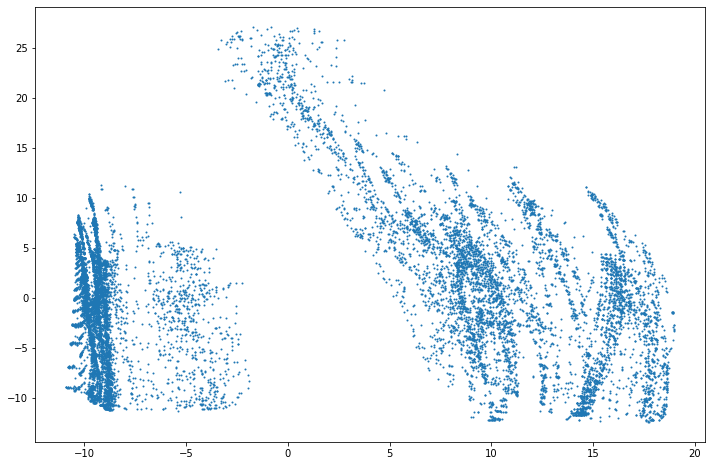

In [30]:
plt.figure(figsize=(12, 8))
plt.scatter(reduced_dimensions[:, 0], reduced_dimensions[:, 1], s=1)

The above plot is what **all** the data looks like in the latent space. Let's pick a (long) particle track and see if the track is projected to be close together:

In [31]:
particles, counts = np.unique(example_data.pid, return_counts=True)

In [32]:
example_particle = particles[counts > 10][0]

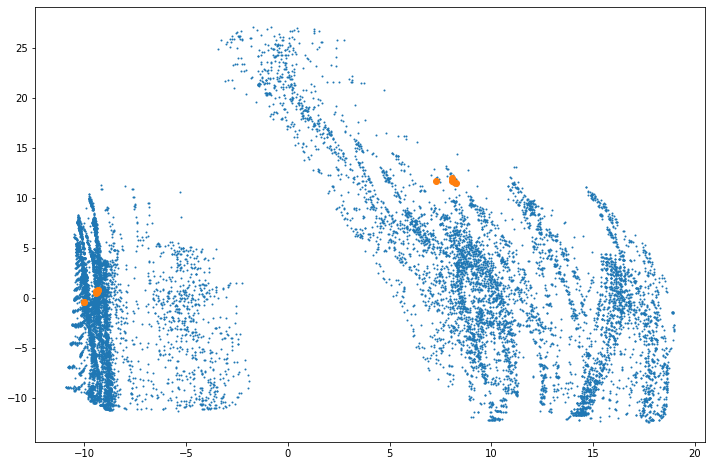

In [33]:
plt.figure(figsize=(12, 8))
plt.scatter(reduced_dimensions[:, 0], reduced_dimensions[:, 1], s=1)
plt.scatter(
    reduced_dimensions[particle_ids == example_particle, 0],
    reduced_dimensions[particle_ids == example_particle, 1],
)

There are at least 10 hits in the plot above. Hopefully some of them cluster together into blobs, and that the blobs are close to other blobs of the same color. We get ~99% efficiency with this model, so even if some blobs appear far away in the PCA-reduced 2D space, they are most likely much closer in the 8-dimensional space. You can check this yourself!

# Building Graphs

In [8]:
model.eval();

In [10]:
dataset_list = []
for dataname in model.hparams["datatype_names"]:
    dataset = os.listdir(os.path.join(model.hparams["input_dir"], dataname))
    dataset = sorted(
        [os.path.join(model.hparams["input_dir"], dataname, event) for event in dataset]
    )
    dataset_list.append(dataset)

In [60]:
class FilterInferenceBuilder:
    def __init__(self, model, output_dir, overwrite=False):
        self.output_dir = output_dir
        self.model = model
        self.overwrite = overwrite

        # Prep the directory to produce inference data to
        self.datatypes = ["train", "val", "test"]
        os.makedirs(self.output_dir, exist_ok=True)
        [
            os.makedirs(os.path.join(self.output_dir, datatype), exist_ok=True)
            for datatype in self.datatypes
        ]

        # Get [train, val, test] lists of files
        self.dataset_list = []
        for dataname in model.hparams["datatype_names"]:
            dataset = os.listdir(os.path.join(model.hparams["input_dir"], dataname))
            dataset = sorted(
                [
                    os.path.join(model.hparams["input_dir"], dataname, event)
                    for event in dataset
                ]
            )[:10]
            self.dataset_list.append(dataset)

    def build(self):
        print("Training finished, running inference to build graphs...")

        # By default, the set of examples propagated through the pipeline will be train+val+test set
        datasets = {
            "train": self.dataset_list[0],
            "val": self.dataset_list[1],
            "test": self.dataset_list[2],
        }
        total_length = sum([len(dataset) for dataset in datasets.values()])
        batch_incr = 0
        self.model.eval()
        with torch.no_grad():
            for set_idx, (datatype, dataset) in enumerate(datasets.items()):
                for event_idx, event_file in enumerate(dataset):
                    percent = (batch_incr / total_length) * 100
                    sys.stdout.flush()
                    sys.stdout.write(f"{percent:.01f}% inference complete \r")
                    batch = torch.load(event_file).to(device)
                    if (
                        not os.path.exists(
                            os.path.join(
                                self.output_dir, datatype, batch.event_file[-4:]
                            )
                        )
                    ) or self.overwrite:
                        batch_to_save = copy.deepcopy(batch)
                        batch_to_save = batch_to_save.to(
                            self.model.device
                        )  # Is this step necessary??
                        self.construct_downstream(batch_to_save, datatype)

                    batch_incr += 1

    def construct_downstream(self, batch, datatype):

        emb = (
            None if (self.model.hparams["emb_channels"] == 0) else batch.embedding
        )  # Does this work??

        cut_list = []
        for j in range(self.model.hparams["n_chunks"]):
            subset_ind = torch.chunk(
                torch.arange(batch.edge_index.shape[1]), self.model.hparams["n_chunks"]
            )[j]
            output = (
                self.model(
                    torch.cat([batch.cell_data, batch.x], axis=-1),
                    batch.edge_index[:, subset_ind],
                    emb,
                ).squeeze()
                if ("ci" in self.model.hparams["regime"])
                else self.model(batch.x, batch.edge_index[:, subset_ind], emb).squeeze()
            )
            cut = torch.sigmoid(output) > self.model.hparams["filter_cut"]
            cut_list.append(cut)

        cut_list = torch.cat(cut_list)

        if "pid" not in self.model.hparams["regime"]:
            batch.y = batch.y[cut_list]

        y_pid = batch.pid[batch.edge_index[0]] == batch.pid[batch.edge_index[1]]
        batch.y_pid = y_pid[cut_list]
        batch.edge_index = batch.edge_index[:, cut_list]
        if "weighting" in self.model.hparams["regime"]:
            batch.weights = batch.weights[cut_list]

        self.save_downstream(batch, datatype)

    def save_downstream(self, batch, datatype):

        with open(
            os.path.join(self.output_dir, datatype, batch.event_file[-4:]), "wb"
        ) as pickle_file:
            torch.save(batch, pickle_file)

In [61]:
output_dir = "/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/filter_processed/0_pt_cut_noise_high_eff"
model.hparams["filter_cut"] = 0.11

edge_builder = FilterInferenceBuilder(model, output_dir, overwrite=False)

In [62]:
edge_builder.build()

Training finished, running inference to build graphs...
